#### Notebook to analyse model trained on only patients MRI-negative and histology confirmed

Support used for JAMA revisions

In [ ]:
import os
import pandas as pd 
import sys
import meld_classifier.paths as paths


## Create the dataset

In [8]:
# get the original dataset with train and test split
orig_df = pd.read_csv(os.path.join(paths.BASE_PATH, 'MELD_dataset_V6.csv'), index_col=0)

#get the list of patients mri neg and histo confirmed
patients_mrineghisto=  pd.read_csv(os.path.join(paths.BASE_PATH, 'list_patients_mrineg_histo.csv'))['ID']

In [3]:
# Extract only patients mrineg and histo confirmed, and controls 

new_df = orig_df[(orig_df['subject_id'].str.contains('_C_')) | (orig_df['subject_id'].isin(patients_mrineghisto))]
new_df = new_df.loc[:, ~new_df.columns.str.contains('^Unnamed')]
new_df = new_df.reset_index(drop=True)
print(len(new_df))
new_df



508


,subject_id,split
0,MELD2_H7_3T_FCD_007,trainval
1,MELD2_H7_3T_FCD_008,trainval
2,MELD_H10_3T_C_0002,trainval
3,MELD_H10_3T_C_0003,trainval
4,MELD_H10_3T_C_0004,trainval
...,...,...
503,MELD_H9_3T_C_0003,trainval
504,MELD_H9_3T_C_0004,trainval
505,MELD_H9_3T_C_0005,test
506,MELD_H9_3T_C_0007,test


In [7]:
(new_df['subject_id'].str.contains('_FCD_')).sum()

135

In [14]:
#save
new_df.to_csv(os.path.join(paths.BASE_PATH, 'MELD_dataset_V6_mrineg&histo.csv'))

## Analyse the performances

In [4]:
from meld_classifier.meld_cohort import MeldCohort,MeldSubject
import h5py
import pandas as pd
import numpy as np
from meld_graph.evaluation import load_prediction

Setting EXPERIMENT_PATH to /rds/project/kw350/rds-kw350-meld/experiments_graph/kw350


In [5]:
def get_results_graph(subjects, cohort, pred_file ):
    df=pd.DataFrame()
    subjects_dictionary={}
    values={}
    for si,subj in enumerate(subjects):
        if si%100==0:
            print(si)
        values['ID']=subj
        if "H101" in subj:
            s = MeldSubject(subj,cohort=cohort2)
        else:
            s = MeldSubject(subj,cohort=cohort)
        values['group']= True if s.group=='patient' else False
        labels_hemis = {}
        dists={}
        labels = np.zeros(len(cohort.cortex_label)*2)
        for hemi in ['lh','rh']:
            dists[hemi], labels_hemis[hemi] = s.load_feature_lesion_data(
                        features=['.on_lh.boundary_zone.mgh'], hemi=hemi, features_to_ignore=[]
                    )
            if np.sum(dists[hemi])==0:
                dists[hemi] +=200
        labels = np.hstack([labels_hemis['lh'][cohort.cortex_mask],labels_hemis['rh'][cohort.cortex_mask]])
        borderzones = np.vstack([dists['lh'][cohort.cortex_mask,:],dists['rh'][cohort.cortex_mask,:]]).ravel()<20
        #load pred from graph classifier

        result_hemis = load_prediction(subj,pred_file, dset='prediction_clustered')
        result = np.hstack([result_hemis['lh'],result_hemis['rh']])
        values['model']='graph'
        
        #add detection with borderzone
        if labels.sum()>0:
            values['detected'] = np.logical_and(result, borderzones).any()
            clusters_in_borderzone = set(result[borderzones.astype('bool')])
            #remove the 0 cluster
            if 0 in clusters_in_borderzone:
                clusters_in_borderzone.remove(0)
            values['number TP clusters'] = len(clusters_in_borderzone)
            values['size_pred'] = len(result[borderzones.astype('bool')])
            values['IOU'] = (np.logical_and(result, labels)).sum() / (np.logical_or(result, labels)).sum() 
            values['IOU_plus'] = (np.logical_and(result, borderzones)).sum() / (np.logical_or(result, borderzones)).sum() 
        
        else:
            values['number TP clusters'] = 0
            values['IOU'] = np.nan
            values['IOU_plus'] = np.nan
        
        # add number of FP clusters : total clusters - TP clusters
        values['number FP clusters']=len(set(result_hemis['lh']))+len(set(result_hemis['rh']))-2-values['number TP clusters']
        df=pd.concat([df,pd.DataFrame([values])])
        
    df = df.reset_index()
    return df

In [6]:

def df_stats(df, metrics=['sensitivity','specificity', 'ppv', 'IOU', 'IOU+']):
    metric_results = []
    for metric in metrics:
        if metric == 'sensitivity':
            sensitivity = np.mean(df['detected'][df['group']])
            metric_results.append(round(sensitivity,2))
        elif metric == 'specificity':
            specificity = (df['number FP clusters'][df['group']==False]==0).mean()
            metric_results.append(round(specificity,2))
        elif metric == 'ppv':
            total_detected = np.sum(df['number TP clusters'][df['group']])
            total_predicted = np.sum(df['number FP clusters'][df['group']])
            ppv = total_detected / (total_predicted + total_detected)
            metric_results.append(round(ppv,2))
        elif metric == 'IOU':
            iou = np.mean(df[(df['group'])&(df['detected'])]['IOU'])
            metric_results.append(round(iou,2))
        elif metric == 'IOU+':
            iou_plus = np.mean(df[(df['group'])&(df['detected'])]['IOU_plus'])
            metric_results.append(round(iou_plus,2))
        else:
            print(f'Metric {metric} does not exist')
            pass
    return metric_results

# bootstrapped confidence intervals
def bootstrap_CI(df, n=10000, func=df_stats):
    """Calculate confidence intervals for a given function"""
    bootstrapped = []
    for i in range(n):
        bootstrapped.append(func(df.sample(len(df), replace=True)))
    return np.percentile(np.array(bootstrapped), [2.5, 97.5],axis=0)

def get_pvalue(stat, distribution):
    p_pos = np.mean(distribution > stat)
    p_neg = np.mean(distribution < stat)
    p = min(p_pos,p_neg)*2
    return p

In [9]:

#load model trained on mrineg+histo only
experiment_dir = ''
model ='24-08-01_MRIN_dcp'   
pred_file = os.path.join(experiment_dir,model,'s_0','fold_all','results_best_model', 'predictions.hdf5')
cohort= MeldCohort(hdf5_file_root='{site_code}_{group}_featurematrix_combat_6_kernels_noCombat.hdf5',
                            dataset='MELD_dataset_v6.csv')
# load mrineg+histo patients in test 
with h5py.File(pred_file, "r") as f:
    subjects = list(f.keys())
#get results
df_mrineg = get_results_graph(subjects, cohort, pred_file)
# print results
dfsub = df_mrineg.copy()
print(len(dfsub))
sensitivity_mlp, specificity_mlp, ppv_mlp, iou_mlp, iou_plus_mlp = df_stats(dfsub)
print('sensitivity specificity ppv iou iou+')
print(sensitivity_mlp,specificity_mlp, ppv_mlp, iou_mlp, iou_plus_mlp)
CI_mlp = bootstrap_CI(dfsub)
print(CI_mlp)


0
100
200
251
sensitivity specificity ppv iou iou+
0.67 0.54 0.58 0.22 0.23
[[0.55 0.47 0.46 0.17 0.18]
 [0.79 0.61 0.72 0.27 0.29]]


In [20]:
df_mrineg.groupby('group')['number FP clusters'].quantile([0.5, 0.25, 0.75, 1])

group      
False  0.50    0.0
       0.25    0.0
       0.75    1.0
       1.00    3.0
True   0.50    0.0
       0.25    0.0
       0.75    1.0
       1.00    4.0
Name: number FP clusters, dtype: float64

In [10]:
#load main Graph model to compare
experiment_dir = ''
model ='23-10-30_LVHZ_dcp'   
pred_file = os.path.join(experiment_dir,model,'s_0','fold_all_newthreshold','results_best_model', 'predictions.hdf5')

#get results on same subjects
df_graph = get_results_graph(subjects, cohort, pred_file)

# print results
dfsub = df_graph.copy()
print(len(dfsub))
sensitivity_mlp, specificity_mlp, ppv_mlp, iou_mlp, iou_plus_mlp = df_stats(dfsub)
print('sensitivity specificity ppv iou iou+')
print(sensitivity_mlp,specificity_mlp, ppv_mlp, iou_mlp, iou_plus_mlp)
CI_mlp = bootstrap_CI(dfsub)
print(CI_mlp)


0
100
200
251
sensitivity specificity ppv iou iou+
0.72 0.6 0.72 0.25 0.21
[[0.6  0.53 0.61 0.19 0.16]
 [0.84 0.67 0.84 0.31 0.27]]


In [22]:
df_graph.groupby('group').count()

,index,ID,model,number TP clusters,IOU,IOU_plus,number FP clusters,detected,size_pred
group,,,,,,,,,
False,193,193,193,193,0,0,193,176,176
True,58,58,58,58,58,58,58,58,58


In [21]:
df_graph.groupby('group')['number FP clusters'].quantile([0.5, 0.25, 0.75, 1])

group      
False  0.50    0.0
       0.25    0.0
       0.75    1.0
       1.00    2.0
True   0.50    0.0
       0.25    0.0
       0.75    0.0
       1.00    3.0
Name: number FP clusters, dtype: float64

0.67 0.54 0.58 0.22
0.72 0.6 0.72 0.25
0.228 0.104 0.006


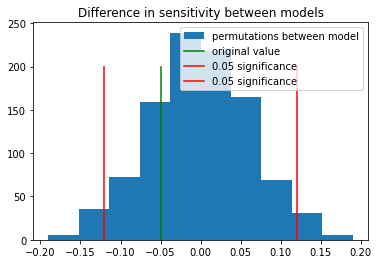

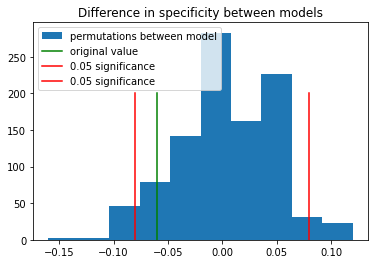

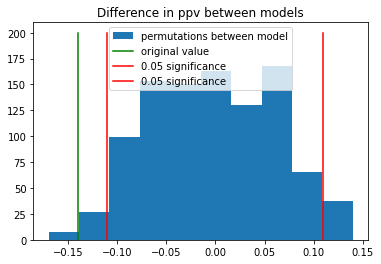

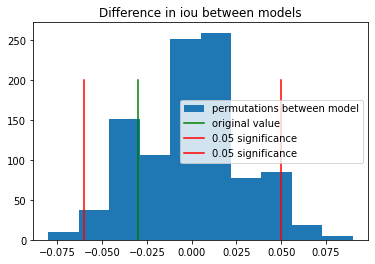

In [19]:
# Compare models with permutation
import matplotlib.pyplot as plt

def permute_models(df):
    for index, row in df.iterrows():
        # Randomly permute the data from column 0 and 1
        permuted_indices = np.random.permutation(2)
        if (permuted_indices == [1,0]).all():
            df.at[index, 'detected_mrineg'], df.at[index, 'detected_Graph'] = \
            row[['detected_mrineg', 'detected_Graph']].values[permuted_indices]
            df.at[index, 'number TP clusters_mrineg'], df.at[index, 'number TP clusters_Graph'] = \
            row[['number TP clusters_mrineg', 'number TP clusters_Graph']].values[permuted_indices]
            df.at[index, 'number FP clusters_mrineg'], df.at[index, 'number FP clusters_Graph'] = \
            row[['number FP clusters_mrineg', 'number FP clusters_Graph']].values[permuted_indices]
            df.at[index, 'IOU_mrineg'], df.at[index, 'IOU_Graph'] = \
            row[['IOU_mrineg', 'IOU_Graph']].values[permuted_indices]
    return df


sensitivity_mrineg_orig, specificity_mrineg_orig, ppv_mrineg_orig, iou_mrineg_orig = df_stats(df_mrineg, 
                                                                             metrics=['sensitivity', 'specificity', 'ppv', 'IOU'])
print(sensitivity_mrineg_orig, specificity_mrineg_orig, ppv_mrineg_orig, iou_mrineg_orig)
sensitivity_graph_orig, specificity_graph_orig, ppv_graph_orig, iou_graph_orig = df_stats(df_graph,  
                                                                                          metrics=['sensitivity', 'specificity', 'ppv', 'IOU'])
print(sensitivity_graph_orig, specificity_graph_orig, ppv_graph_orig, iou_graph_orig)
#compute difference
diff_sensitivity_orig = sensitivity_mrineg_orig - sensitivity_graph_orig
diff_specificity_orig = specificity_mrineg_orig - specificity_graph_orig
diff_ppv_orig = ppv_mrineg_orig - ppv_graph_orig
diff_iou_orig = iou_mrineg_orig - iou_graph_orig

#combine results for mrineg and Graph 
df_comp = df_mrineg[['ID','group','detected','number TP clusters','number FP clusters', 'IOU']].merge(df_graph[['ID','group','detected','number TP clusters','number FP clusters', 'IOU']], how='left', on=['ID','group'], suffixes=['_mrineg','_Graph'])

diffs_sensitivity = []
diffs_specificity = []
diffs_ppv = []
diffs_iou = []
for i in range(0,1000):
    # shuffle models
    df_shuffle = permute_models(df_comp.copy())
    
    # compute metrics again
    df_shuffle_mrineg = pd.DataFrame()
    df_shuffle_mrineg[['group','detected','number TP clusters','number FP clusters', 'IOU']] = df_shuffle[['group','detected_mrineg','number TP clusters_mrineg','number FP clusters_mrineg', 'IOU_mrineg']].copy()
    sensitivity_mrineg_i, specificity_mrineg_i, ppv_mrineg_i, iou_mrineg_i = df_stats(df_shuffle_mrineg, 
                                                                        metrics=['sensitivity', 'specificity', 'ppv','IOU'])
    
    df_shuffle_graph = pd.DataFrame()
    df_shuffle_graph[['group','detected','number TP clusters','number FP clusters', 'IOU']] = df_shuffle[['group','detected_Graph','number TP clusters_Graph','number FP clusters_Graph', 'IOU_Graph']].copy()
    sensitivity_graph_i, specificity_graph_i, ppv_graph_i, iou_graph_i= df_stats(df_shuffle_graph, 
                                                                    metrics=['sensitivity', 'specificity', 'ppv', 'IOU'])
    
    # find differences
    diffs_sensitivity.append(sensitivity_mrineg_i - sensitivity_graph_i)
    diffs_specificity.append(specificity_mrineg_i - specificity_graph_i)
    diffs_ppv.append(ppv_mrineg_i - ppv_graph_i)
    diffs_iou.append(iou_mrineg_i - iou_graph_i)

#compute pvalue
p_sensitivity = get_pvalue(diff_sensitivity_orig, diffs_sensitivity)
p_specificity = get_pvalue(diff_specificity_orig, diffs_specificity)
p_ppv = get_pvalue(diff_ppv_orig, diffs_ppv)
p_iou = get_pvalue(diff_iou_orig, diffs_iou)
print(p_sensitivity, p_specificity, p_ppv)

#plot results shuffle
plt.figure()
plt.hist(diffs_sensitivity, label='permutations between model')
#add results orig
plt.plot([diff_sensitivity_orig,diff_sensitivity_orig], [0,200], label='original value', color='green')
#add 5% significance lines
lines5 = np.percentile(diffs_sensitivity, [2.5, 97.5])
plt.plot([lines5[0],lines5[0]], [0,200], label='0.05 significance', color='red')
plt.plot([lines5[1],lines5[1]], [0,200], label='0.05 significance', color='red')
plt.title('Difference in sensitivity between models')
plt.legend()

plt.figure()
plt.hist(diffs_specificity, label='permutations between model')
#add results orig
plt.plot([diff_specificity_orig,diff_specificity_orig], [0,200], label='original value', color='green')
#add 5% significance lines
lines5 = np.percentile(diffs_specificity, [2.5, 97.5])
plt.plot([lines5[0],lines5[0]], [0,200], label='0.05 significance', color='red')
plt.plot([lines5[1],lines5[1]], [0,200], label='0.05 significance', color='red')
plt.title('Difference in specificity between models')
plt.legend()

plt.figure()
plt.hist(diffs_ppv, label='permutations between model')
#add results orig
plt.plot([diff_ppv_orig,diff_ppv_orig], [0,200], label='original value', color='green')
#add 5% significance lines
lines5 = np.percentile(diffs_ppv, [2.5, 97.5])
plt.plot([lines5[0],lines5[0]], [0,200], label='0.05 significance', color='red')
plt.plot([lines5[1],lines5[1]], [0,200], label='0.05 significance', color='red')
plt.title('Difference in ppv between models')
plt.legend()

plt.figure()
plt.hist(diffs_iou, label='permutations between model')
#add results orig
plt.plot([diff_iou_orig,diff_iou_orig], [0,200], label='original value', color='green')
#add 5% significance lines
lines5 = np.percentile(diffs_iou, [2.5, 97.5])
plt.plot([lines5[0],lines5[0]], [0,200], label='0.05 significance', color='red')
plt.plot([lines5[1],lines5[1]], [0,200], label='0.05 significance', color='red')
plt.title('Difference in iou between models')
plt.legend()

